## Hyper Params

In [1]:
Z_LENGTH = 5
NUM_LAYERS = 3
MODEL = './assets/pretrained_models/mnist/last.ckpt'

## Define & Load Model

In [2]:
import tensorflow as tf
import numpy as np
from functools import partial

import arch
import dataset
import wae

x_ph = tf.placeholder(tf.float32,[None,28,28,1])
z_ph = tf.placeholder(tf.float32,[None,Z_LENGTH])

ds = dataset.MNIST(1) #Given batch size is not used.

p_z = arch.Pseudo_P_Z(z_ph)

Q_arch = partial(arch.fc_arch,
                 input_shape=(784,),
                 output_size=Z_LENGTH,
                 num_layers=NUM_LAYERS,
                 embed_size=256)
G_arch = partial(arch.fc_arch,
                 input_shape=(Z_LENGTH,),
                 output_size=784, # # of generated pixels
                 num_layers=NUM_LAYERS,
                 embed_size=256)
D_arch = partial(arch.fc_arch,
                 input_shape=(Z_LENGTH,), # shape when flattened.
                 output_size=1,
                 num_layers=NUM_LAYERS,
                 embed_size=64,
                 act_fn='ELU-like')

with tf.variable_scope('param_scope') as scope:
    pass

model = \
    wae.WAE_WGAN(x_ph,
                 p_z,
                 Q_arch,
                 G_arch,
                 D_arch,
                 0.0,
                 lambda x,y: tf.reduce_sum(tf.abs(x-y),axis=(1,2,3)), #use l1_distance for recon loss
                 None,
                 scope)

init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

# Execute Training!
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)

# Init variables and load weights
sess.run(init_op)
model.load(MODEL)

save vars:
/D/linear_0/b
/D/linear_0/w
/D/linear_1/b
/D/linear_1/w
/D/linear_2/b
/D/linear_2/w
/D/linear_3/b
/D/linear_3/w
/G/linear_0/b
/G/linear_0/w
/G/linear_1/b
/G/linear_1/w
/G/linear_2/b
/G/linear_2/w
/G/linear_3/b
/G/linear_3/w
/Q/linear_0/b
/Q/linear_0/w
/Q/linear_1/b
/Q/linear_1/w
/Q/linear_2/b
/Q/linear_2/w
/Q/linear_3/b
/Q/linear_3/w
INFO:tensorflow:Restoring parameters from ./assets/pretrained_models/mnist/last.ckpt


## Reconstruction Result

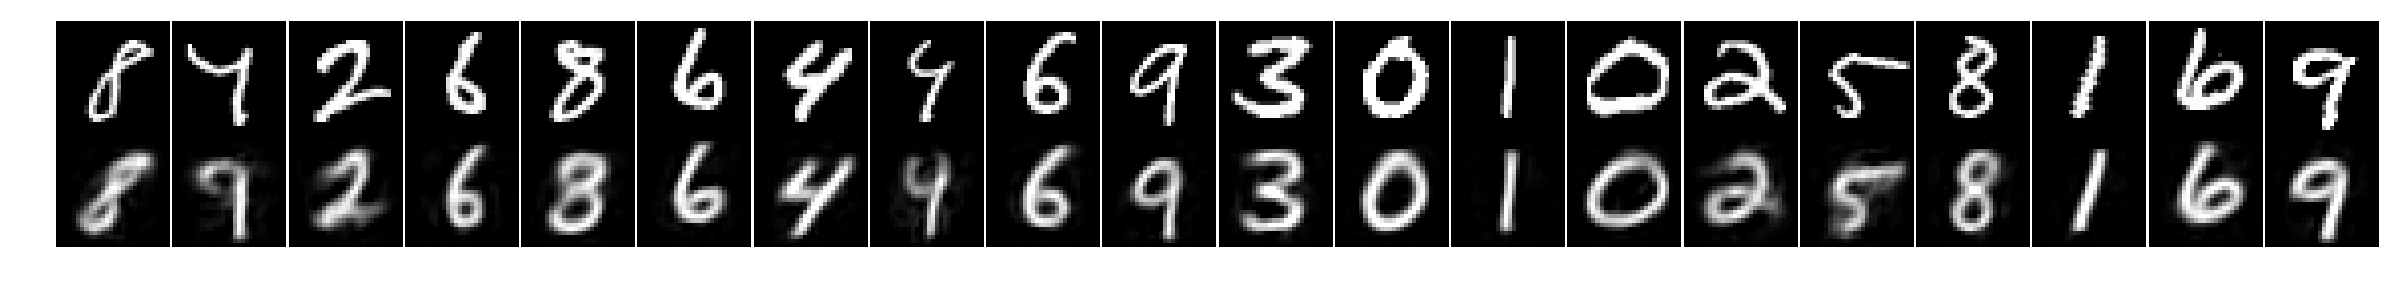

In [5]:
def draw(images):
    x,y,h,w,c = images.shape
    if c == 1:
        images = np.squeeze(images)
    
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(y,x),dpi=150)
    
    for i in range(x):
        for j in range(y):
            a = fig.add_subplot(x,y, (i*y+j) + 1)
            a.imshow( images[i,j], cmap='gray' )
            a.axis('off')
            a.set_aspect('equal')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    plt.close()
    
valid_ims = ds.ims[50000:]

x = valid_ims[np.random.choice(len(valid_ims),20)]
recon_x = sess.run(model.x_recon, feed_dict={x_ph:x})

draw(np.stack([x,recon_x],axis=0))

(top): original images from MNIST validation set, (bottom): reconstructed image

## Random Sampled Images

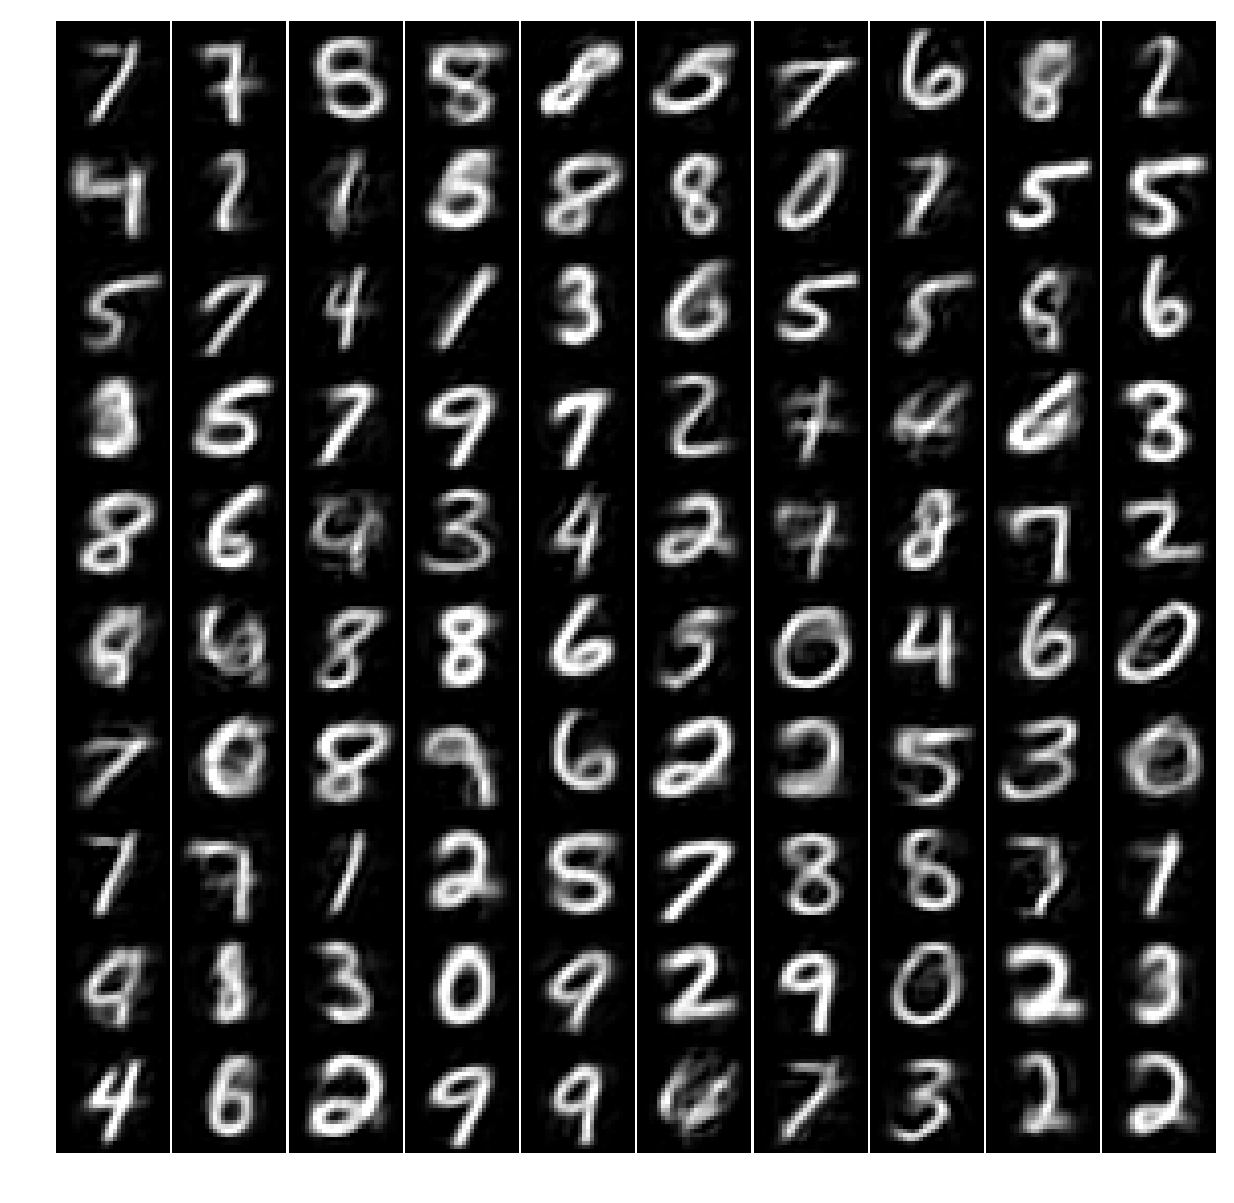

In [4]:
sampled = \
    sess.run(model.x_sample, 
         feed_dict={x_ph:np.zeros((100,28,28,1)), # Not used; just used for inferencing image shape
                    z_ph:np.random.normal(loc=0.0, scale=1.0, size=(100,Z_LENGTH))})
sampled = np.reshape(sampled,[10,10,28,28,1])
draw(sampled)